In [2]:
from random import randrange
from scipy.stats import ttest_ind, ttest_1samp
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import random


In [3]:
diet = [randrange(8,14) for _ in range(13)]
nodiet = [randrange(7,18) for _ in range(15)]

print(f"""
The people who followed the diet had the following apnea events: {diet}, 
While those who didn't follow the diet had the following apnea events: {nodiet}.
""")


The people who followed the diet had the following apnea events: [12, 12, 8, 13, 10, 10, 8, 10, 10, 12, 10, 8, 12], 
While those who didn't follow the diet had the following apnea events: [17, 14, 17, 8, 13, 15, 8, 12, 12, 16, 17, 13, 14, 15, 13].



In [4]:
res = ttest_ind(diet, nodiet, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.5f}')

p-value for single sided test: 0.00062


## Permutation test

Write your own Python implementation of a permutation test to generate 1,000 resamples; in each iteration perform a one-sided t-test and record the p-value.

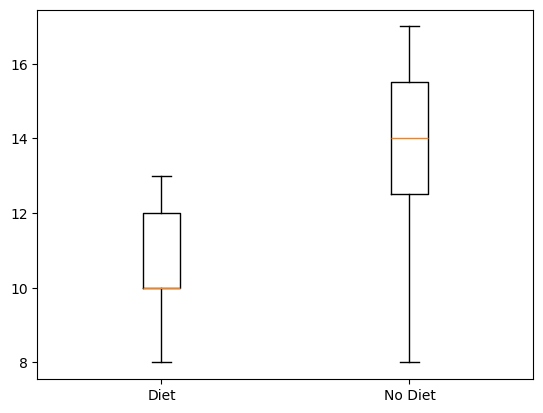

In [5]:
import pandas as pd

treatment = ['diet'] * len(diet)
treatment.extend(['nodiet'] * len(nodiet))

df = pd.DataFrame({'treatment': treatment, 'n_events': diet + nodiet})
# df
plt.boxplot([diet, nodiet], labels=['Diet', 'No Diet'])
plt.show()

In [6]:
mean_diet = df[df.treatment == 'diet'].n_events.mean()
mean_nodiet = df[df.treatment == 'nodiet'].n_events.mean()
observed_difference = mean_nodiet - mean_diet
observed_difference

3.2153846153846146

In [7]:
def perm_func(df):
    df = df.copy()
    n_diet = df[df.treatment == 'diet'].n_events.shape[0]
    n_nodiet = df[df.treatment == 'nodiet'].n_events.shape[0]
    n = n_diet + n_nodiet
    idx_diet = set(random.sample(range(n), n_diet))  #  note we're permuting indices, not values
    idx_nodiet = set(range(n)) - idx_diet       #  the set of indices for nodiet is created by removing all indices that are assigned to diet
    return df.n_events.loc[list(idx_diet)].mean() - df.n_events.loc[list(idx_nodiet)].mean() 

diffs = [perm_func(df) for _ in range(2000)]

# we want to know how often the sample mean is greater than the difference in mean[diet] - mean[nodiet]
# so this is a proportion of Trues in the array
p_value = np.mean(np.array(diffs) > observed_difference)
p_value

0.0005

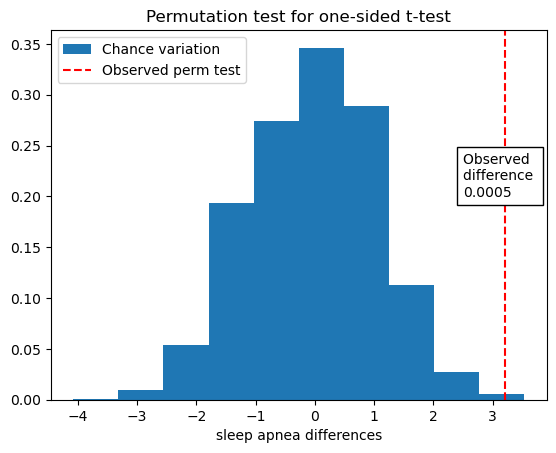

In [8]:
# plt.figure(figsize=(10,10))
plt.hist(diffs, label='Chance variation', density=True)
plt.axvline(observed_difference, linestyle='--', c='r', label='Observed perm test')
# plt.axhline(res.pvalue / 2, linestyle=':', c='r', label='Observed scipy ttest') # the y-axis represents the probability density, not the p-value
plt.title('Permutation test for one-sided t-test')
plt.xlabel('sleep apnea differences')
plt.text(2.5,0.2, f'Observed \ndifference \n{p_value}', bbox={'facecolor':'white'})
plt.legend()
plt.show()

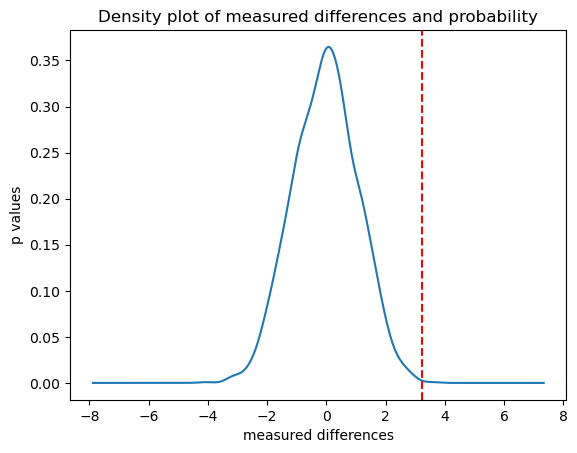

In [9]:
ax = pd.Series(diffs).plot.density()
ax.axvline(observed_difference, linestyle='--', c='r', label='Observed perm test')
plt.title('Density plot of measured differences and probability')
plt.xlabel("measured differences")
plt.ylabel("p values")
plt.show()

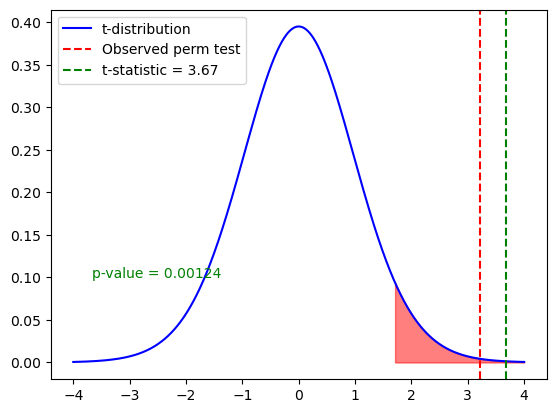

In [10]:
from scipy.stats import t

t_stat, p_value = ttest_ind(diet, nodiet, equal_var=False)
df = len(diet) + len(nodiet) - 2

x = np.linspace(-4, 4, 1000)
y = t.pdf(x, df)

plt.plot(x, y, 'b-', label='t-distribution')
plt.axvline(observed_difference, linestyle='--', c='r', label='Observed perm test')

# Critical regions for alpha = 0.05
alpha = 0.05
critical_value = t.ppf(1 - alpha, df) # normally alpha / 2 (two-tailed)
plt.fill_between(x, 0, y, where=(x >= critical_value), color='red', alpha=0.5) # type: ignore
# plt.fill_between(x, 0, y, where=(x <= -critical_value), color='red', alpha=0.5) 

plt.axvline(-t_stat, color='green', linestyle='--', label=f't-statistic = {-t_stat:.2f}')
plt.text(t_stat, 0.1, f'p-value = {p_value:.5f}', color='green')

# Mark the test statistic
plt.legend()
plt.show()

Note: 
- p-value is a percentage
- t-statistics is "studentised" ie. scaled to a t distribution and measures in stderrs 

### PMF and PDF:
**For discrete random variables:** the PMF describes the distribution by specifying the probability that the variable takes on each of its possible discrete values
When we specify a PMF, **we are assuming that the random variable follows a particular discrete distribution**. Examples include the Binomial distribution, Poisson distribution, Geometric distribution, etc. Each of these distributions has its own PMF.

**For continuous random variables:** The PDF describes the distribution by specifying the density of the variable at each point. When we specify a PDF, we are assuming that the random variable follows a particular continuous distribution. Examples include the Normal distribution, Exponential distribution, Uniform distribution, etc. Each of these distributions has its own PDF.

Eg. for the normal distribution, we assume:
$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}} \quad \text{for} \quad -\infty < x < \infty
$$
This PDF describes the bell-shaped curve typical of the Normal distribution, indicating how the values of 𝑋 are distributed around the mean 𝜇.

For a probability density function (PDF) of a continuous random variable, the area under the curve over a certain interval represents the probability that the random variable falls within that interval. The total area under the entire curve of a PDF is always 1, representing the total probability. Similarly, for a probability mass function (PMF) of a discrete random variable, the "area" under the curve (sum of the probabilities) over all possible values is also 1.

The **expectation** or **expected value** typically refers to the mean value under the null hypothesis. 

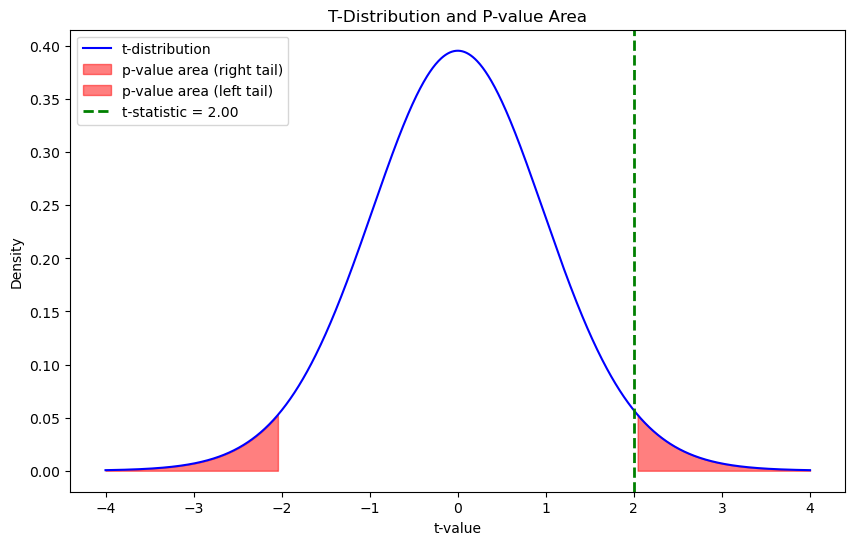

In [11]:
# Parameters
mean_diff = 2  # example difference in means
se_diff = 1  # example standard error of the difference
t_statistic = mean_diff / se_diff  # t-statistic calculation
df = 30  # degrees of freedom

# T-distribution
x = np.linspace(-4, 4, 1000)
y = stats.t.pdf(x, df)

# Plotting
plt.figure(figsize=(10, 6))

# T-distribution curve
plt.plot(x, y, label='t-distribution', color='blue')

# Shading the p-value area for a two-tailed test
crit_value = stats.t.ppf(1 - 0.025, df)
x_fill = np.linspace(crit_value, 4, 500)
y_fill = stats.t.pdf(x_fill, df)
plt.fill_between(x_fill, y_fill, color='red', alpha=0.5, label='p-value area (right tail)')

x_fill = np.linspace(-4, -crit_value, 500)
y_fill = stats.t.pdf(x_fill, df)
plt.fill_between(x_fill, y_fill, color='red', alpha=0.5, label='p-value area (left tail)')

# Indicating the t-statistic
plt.axvline(t_statistic, color='green', linestyle='--', linewidth=2, label=f't-statistic = {t_statistic:.2f}')

# Labels and legend
plt.title('T-Distribution and P-value Area')
plt.xlabel('t-value')
plt.ylabel('Density')
plt.legend()

plt.show()

In [13]:
import statsmodels.api as sm

analysis = sm.stats.TTestIndPower()

# a minimum size of the effect you want to detect
effect_size = sm.stats.proportion_effectsize(0.0121,0.011)
                    
sample_size = analysis.solve_power(effect_size=effect_size,
                                    alpha=0.05,     
                                    power=0.8,       # the probability of detecting that effect
                                    alternative='larger'
                                    )

f"required sample size: {sample_size:.0f}"

'required sample size: 116602'

In [14]:
effect_size

0.01029785095103608

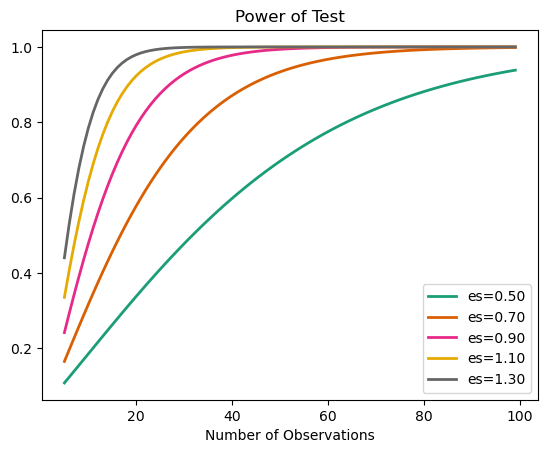

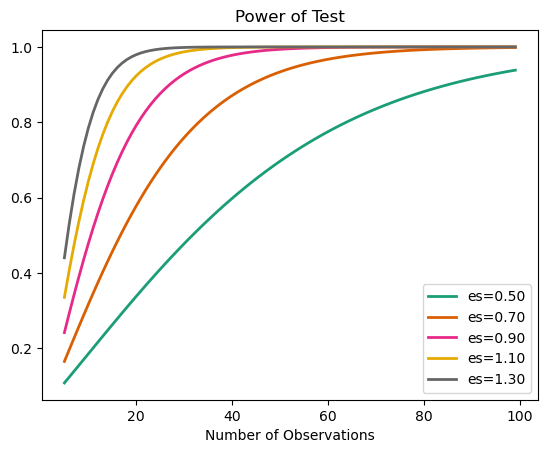

In [21]:
analysis.plot_power(dep_var="nobs",
                    nobs=np.arange(5, 100),
                    effect_size=np.arange(0.5, 1.5, .2),
                    alpha=0.05,
                    # ax=ax,
                )